In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-image-dataset/meta_data.csv
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/meta_data.csv
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/626208_sat_04.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/15573_sat_26.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/749523_sat_70.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/830444_sat_35.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/340898_sat_47.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/563092_sat_47.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/119079_sat_71.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/296279_sat_35.jpg
/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/134465_sat_34.jpg
/kaggle/input/aerial-im

I'm going to import the necessary library.

In [2]:
# Library
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import random
import glob
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

I'm going to create the path for the image and the mask dataset.

In [3]:
# Create path for the image and the mask
image_path = '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/*.jpg'
mask_path = '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/*.jpg'

In order to make the image and the mask dataset in the same order, I'm going to sort it by using `sorted()` function and sort it based on the path before *jpg.

In [4]:
# Sorting the image and the mask dataset
image_dataset = sorted(glob.glob(image_path), key = lambda x: x.split('.')[0])
mask_dataset = sorted(glob.glob(mask_path), key = lambda x: x.split('.')[0])

Let's check if the image and mask dataset have been in the same order.

In [5]:
image_dataset[:5]

['/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/10452_sat_18.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/111335_sat_00.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/111335_sat_01.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/images/111335_sat_02.jpg']

In [6]:
mask_dataset[:5]

['/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/10452_mask_08.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/10452_mask_18.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/111335_mask_00.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/111335_mask_01.jpg',
 '/kaggle/input/aerial-image-dataset/Forest Segmented/Forest Segmented/masks/111335_mask_02.jpg']

We can see from the output that both of the dataset have been in the same order.

I'm going to read and resize the image and the mask by using OpenCV.

In [7]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [8]:
# Resizing the image
image_array = []

for image in image_dataset:
    img = cv2.imread(image) # Using 1 (by default) to read image in unchanged color mode
    img = cv2.resize(img, (64, 64))
    image_array.append(img)
    
image_array = np.array(image_array)

In [9]:
# Resizing the mask
mask_array = []

for mask in mask_dataset:
    msk = cv2.imread(mask, 0) # Using 0 to read image in grayscale mode
    msk = cv2.resize(msk, (64, 64))
    mask_array.append(msk)
    
mask_array = np.array(mask_array)

Let's check the array & the shape and the length of the array of the image and mask array.

In [10]:
print(f"Image array: {image_array[0]}\n")
print(f"Image shape: {image_array.shape}\n")
print(f"Image array length: {len(image_array)}\n")

print(f"Mask array: {mask_array[0]}\n")
print(f"Mask shape: {mask_array.shape}\n")
print(f"Mask array length: {len(mask_array)}\n")

Image array: [[[55 86 85]
  [54 84 85]
  [55 85 87]
  ...
  [61 84 71]
  [53 76 62]
  [36 57 45]]

 [[53 84 83]
  [54 84 85]
  [57 87 88]
  ...
  [43 65 53]
  [58 80 65]
  [52 71 58]]

 [[55 85 86]
  [57 88 87]
  [58 87 86]
  ...
  [39 58 48]
  [54 73 60]
  [64 82 67]]

 ...

 [[60 88 95]
  [59 87 94]
  [57 86 91]
  ...
  [57 77 78]
  [52 68 64]
  [45 61 49]]

 [[61 88 98]
  [61 89 96]
  [61 87 94]
  ...
  [54 74 75]
  [46 62 58]
  [38 53 44]]

 [[61 88 98]
  [60 87 96]
  [62 88 95]
  ...
  [57 77 78]
  [56 72 68]
  [51 67 57]]]

Image shape: (5108, 64, 64, 3)

Image array length: 5108

Mask array: [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 254 255 255]
 [  0   0   0 ... 253 255 255]]

Mask shape: (5108, 64, 64)

Mask array length: 5108



The shape of the image array is (5108, 64, 64, 3).
The shape of the mask array is (5108, 64, 64).
The length of the image and the mask array are 5108.

Let's normalize the array by divide it by 255 (the maximum value of mask array).

In [11]:
# Normalization
X = image_array / 255
y = mask_array / 255

Let's check the array of X and y & the shape and the length of the array of X and y.

In [12]:
print(f"X: {X[0]}\n")
print(f"X shape: {X.shape}\n")
print(f"X length: {len(X)}\n")

print(f"y: {y[0]}\n")
print(f"y shape: {y.shape}\n")
print(f"y length: {len(y)}\n")

X: [[[0.21568627 0.3372549  0.33333333]
  [0.21176471 0.32941176 0.33333333]
  [0.21568627 0.33333333 0.34117647]
  ...
  [0.23921569 0.32941176 0.27843137]
  [0.20784314 0.29803922 0.24313725]
  [0.14117647 0.22352941 0.17647059]]

 [[0.20784314 0.32941176 0.3254902 ]
  [0.21176471 0.32941176 0.33333333]
  [0.22352941 0.34117647 0.34509804]
  ...
  [0.16862745 0.25490196 0.20784314]
  [0.22745098 0.31372549 0.25490196]
  [0.20392157 0.27843137 0.22745098]]

 [[0.21568627 0.33333333 0.3372549 ]
  [0.22352941 0.34509804 0.34117647]
  [0.22745098 0.34117647 0.3372549 ]
  ...
  [0.15294118 0.22745098 0.18823529]
  [0.21176471 0.28627451 0.23529412]
  [0.25098039 0.32156863 0.2627451 ]]

 ...

 [[0.23529412 0.34509804 0.37254902]
  [0.23137255 0.34117647 0.36862745]
  [0.22352941 0.3372549  0.35686275]
  ...
  [0.22352941 0.30196078 0.30588235]
  [0.20392157 0.26666667 0.25098039]
  [0.17647059 0.23921569 0.19215686]]

 [[0.23921569 0.34509804 0.38431373]
  [0.23921569 0.34901961 0.3764705

The shape of the X array is (5108, 64, 64, 3).
The shape of the y array is (5108, 64, 64).
The length of the X and the y array are 5108.

Let's visualize the image and the mask after being processed.

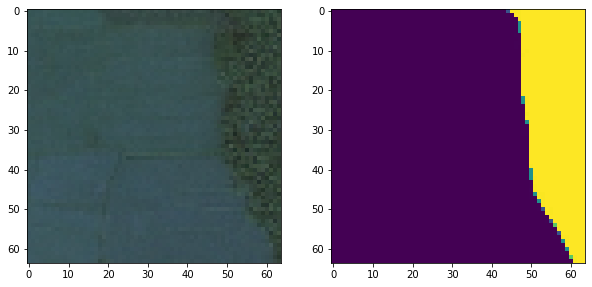

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (10,10))

ax[0].imshow(X[0])
ax[1].imshow(y[0])

Let's split the X and y into train and test dataset for each X and y.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 23)

Let's check the X_train, X_test, y_train, y_test (array, shape, and the length).

In [15]:
print(f"X_train: {X_train[0]}\n")
print(f"X_train shape: {X_train.shape}\n")
print(f"X_train length: {len(X_train)}\n")

print(f"X_test: {X_test[0]}\n")
print(f"X_test shape: {X_test.shape}\n")
print(f"X_test length: {len(X_test)}\n")

print(f"y_train: {y_train[0]}\n")
print(f"y_train shape: {y_train.shape}\n")
print(f"y_train length: {len(y_train)}\n")

print(f"y_test: {y_test[0]}\n")
print(f"y_test shape: {y_test.shape}\n")
print(f"y_test length: {len(y_test)}\n")

X_train: [[[0.39215686 0.50196078 0.54117647]
  [0.3254902  0.43529412 0.47843137]
  [0.28235294 0.38823529 0.43921569]
  ...
  [0.27843137 0.38823529 0.45490196]
  [0.27843137 0.38039216 0.44313725]
  [0.25882353 0.36078431 0.42352941]]

 [[0.34117647 0.45098039 0.49019608]
  [0.36078431 0.47058824 0.50980392]
  [0.28627451 0.39607843 0.43529412]
  ...
  [0.25098039 0.36078431 0.42352941]
  [0.27058824 0.38039216 0.44313725]
  [0.2745098  0.38039216 0.45098039]]

 [[0.25882353 0.36470588 0.42745098]
  [0.2745098  0.38039216 0.43921569]
  [0.27058824 0.37647059 0.43137255]
  ...
  [0.24313725 0.34901961 0.41568627]
  [0.2745098  0.38431373 0.45098039]
  [0.28235294 0.39607843 0.47058824]]

 ...

 [[0.17254902 0.24313725 0.21568627]
  [0.25098039 0.3254902  0.29803922]
  [0.23921569 0.32156863 0.30980392]
  ...
  [0.25882353 0.36078431 0.42352941]
  [0.25490196 0.35686275 0.41960784]
  [0.28627451 0.37647059 0.42745098]]

 [[0.21568627 0.31764706 0.2627451 ]
  [0.27843137 0.36862745 0.3

Let's define  a function for a model by using U-Net model. For the U-Net model, I'm going to use the soft attention because soft attention involves a weighted sum of the features of the input image to determine the final output. Since the soft attention involves the weighting in training, the model will get better at deciding which parts to pay attention to rather than the hard attention that apply the weights to many patches in the image.

For the architecture I've build below is based on my experiments for finding which architecture has the good result on the accuracy and the IoU score.

In [16]:
# Define function for the downward part of convolutions in the U-Net model
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:
# Define function for the upward part of convolutions in the U-Net model
def upsampling_block(expansive_input, contractive_input, n_filters = 32):

    up = Conv2DTranspose(n_filters, # number of filters
                         3, # Kernel size
                         strides = (2,2),
                         padding = 'same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis = 3)
    conv = Conv2D(n_filters, # Number of filters
                 3, # Kernel size
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                 3, # Kernel size
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv)

    return conv

In [18]:
# Define function for combining the upward and downward part of convolutions in the U-Net model
def unet_model(input_size = (64,64, 3), n_filters = 32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2 * n_filters)
    cblock3 = conv_block(cblock2[0], 2**2 * n_filters)
    cblock4 = conv_block(cblock3[0], 2**3 * n_filters, dropout_prob = 0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4 * n_filters, dropout_prob = 0.3, max_pooling = False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1], 2**3 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1], 2**2 * n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1], 2 * n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                   3,
                   activation = 'relu',
                   padding = 'same',
                   kernel_initializer = 'he_normal')(ublock9)

    conv10 = Conv2D(1, 1, 
                    padding = 'same', 
                    activation = 'sigmoid')(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    return model

In [19]:
# creating a U-Net model
model = unet_model(n_filters = 32, input_size = (64, 64, 3))

# Compiling a model
# Let's use the binary_crossentropy loss function 
# since we have only two output fields: forest area and non-forest area
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

2023-02-06 18:49:57.695149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Let's define early stopping callbacks in order to stop the training process if the performance of a traing data has stopped improving.

In [21]:
early_stopping_cb = EarlyStopping(patience = 5, restore_best_weights = True)

Let's train the data.

In [22]:
num_epochs = 100

history = model.fit(X_train, y_train,
                    epochs = num_epochs,
                    callbacks = early_stopping_cb, 
                    validation_data = (X_test, y_test))

2023-02-06 18:49:58.519358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
144/144 [==============================] - 186s 1s/step - loss: 0.5925 - accuracy: 0.6851 - val_loss: 0.5500 - val_accuracy: 0.7325
Epoch 2/100
144/144 [==============================] - 186s 1s/step - loss: 0.5268 - accuracy: 0.7428 - val_loss: 0.4959 - val_accuracy: 0.7548
Epoch 3/100
144/144 [==============================] - 187s 1s/step - loss: 0.4902 - accuracy: 0.7629 - val_loss: 0.4877 - val_accuracy: 0.7717
Epoch 4/100
144/144 [==============================] - 186s 1s/step - loss: 0.5350 - accuracy: 0.7493 - val_loss: 0.5272 - val_accuracy: 0.7486
Epoch 5/100
144/144 [==============================] - 186s 1s/step - loss: 0.5134 - accuracy: 0.7472 - val_loss: 0.4750 - val_accuracy: 0.7743
Epoch 6/100
144/144 [==============================] - 185s 1s/step - loss: 0.4800 - accuracy: 0.7677 - val_loss: 0.4523 - val_accuracy: 0.7861
Epoch 7/100
144/144 [==============================] - 186s 1s/step - loss: 0.4696 - accuracy: 0.7740 - val_loss: 0.4735 - val_accuracy:

Let's plot the result of the original image, the predicted and the original mask.

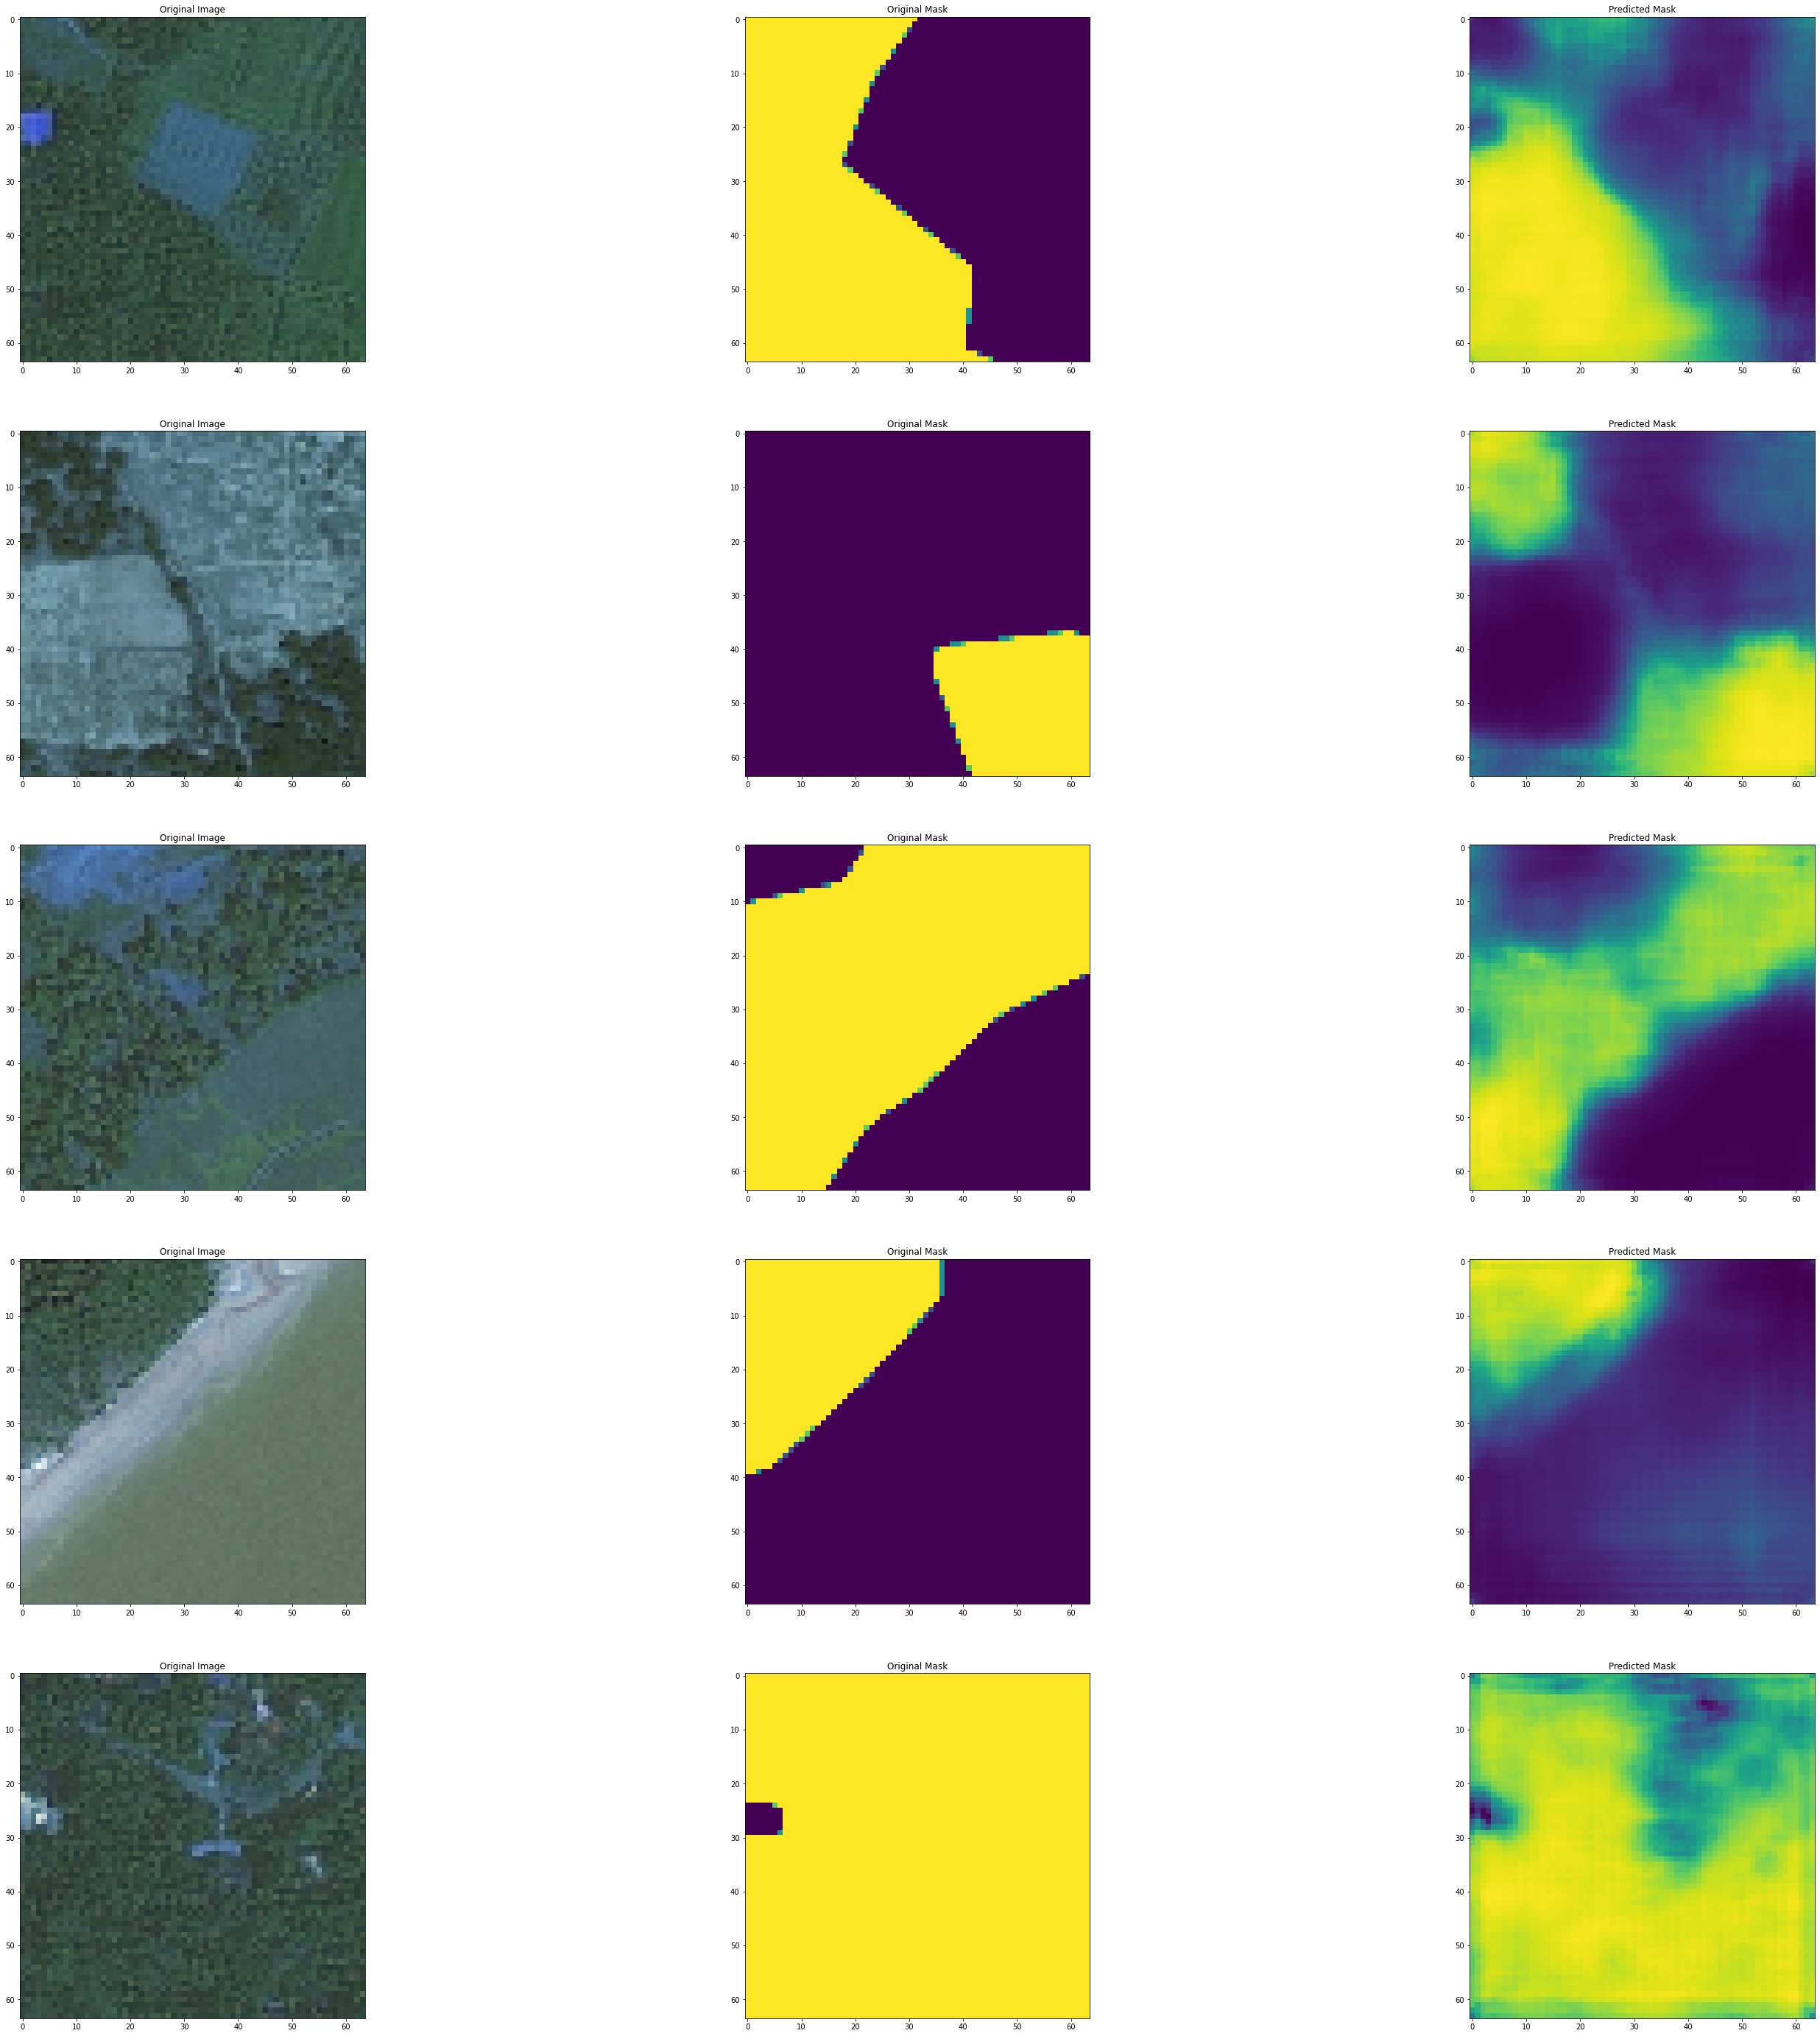

In [23]:
figure, axes = plt.subplots(5, 3, figsize = (50, 50))

for i in range(0,5):
    rand_num = random.randint(0, 500)
    
    # Plot the original image
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    # Plot the original mask
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    # Plot the predicted mask
    original_img = np.expand_dims(original_img, axis = 0)
    predicted_mask = model.predict(original_img).reshape(64,64)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')

Let's check the accuracy and the IoU score.

In [24]:
# Check accuracy
_, acc = model.evaluate(X_test, y_test, verbose = 0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.808


Based on the output above, the accuracy is 81.3% and the accuracy is considered a good result.

In [25]:
# Check IoU Score
def IoU(original_mask, predicted_mask):
    original_mask = original_mask.astype(bool)
    predicted_mask = predicted_mask.astype(bool)

    intersection = np.logical_and(original_mask, predicted_mask)
    union = np.logical_or(original_mask, predicted_mask)

    iou = np.sum(intersection) / np.sum(union)
    return iou

iou = IoU(original_mask, predicted_mask)
print("IoU score: ", iou)

IoU score:  0.991943359375


Based on the output above, the predicted bounding box covers 52.441% of the ground truth bounding box and the ground truth bounding box covers the predicted bounding box by the same percentage. Since the IoU score above 0.5 is considered a good result.